In [16]:
import os
import warnings
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#os.environ['CUDA_LAUNCH_BLOCKING'] = str(1)
#os.environ["TORCH_USE_CUDA_DSA"]= str(0)
warnings.filterwarnings('ignore') 


In [17]:
import copy
from copy import deepcopy
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from collections import OrderedDict
import random
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset
import sys
import torch
import numpy as np
from tqdm import trange
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import mne
from sklearn.preprocessing import StandardScaler
import logging
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence
import statistics
import torch.optim.lr_scheduler as lr_scheduler
from scipy.special import softmax
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay

In [18]:
logging.getLogger('mne').setLevel(logging.WARNING)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import import_ipynb
#from Model import net
from Dataloader4 import EEGDataset

importing Jupyter notebook from Dataloader4.ipynb


In [19]:
torch.__version__

'2.1.1+cu118'

In [20]:
def Accuracy(y_pred, y, train_count):
    max_values, _ = torch.max(y_pred, dim=1, keepdim=True)
    mask = y_pred == max_values
    y_pred = mask.int()
    correct_num = torch.sum(torch.all(torch.eq(y, y_pred), dim=1)).item()
    accuracy = correct_num / train_count
    return accuracy * 100

In [21]:
def average_weights(models):
    new_model = deepcopy(config)

    # Get the parameters of the new model
    new_params = dict(new_model.named_parameters())

    # Iterate over the layers
    for name, param in new_params.items():
        # Compute the average of weights from the 5 models
        avg_weight = sum(model.state_dict()[name] for model in models) / len(models)
        param.data.copy_(avg_weight)

    return new_model

In [22]:
def test(model, test_path, test_class, verbose=True):
    x_test = mne.read_epochs(test_path, preload=False).get_data(picks='eeg');
    normals = []
    scaler = StandardScaler()
    for idx in range(len(x_test)):
        normals.append(scaler.fit_transform(x_test[idx]))
    normals = copy.deepcopy(np.array(normals))
    normals = torch.tensor(normals).cuda().float()
    out = model(normals)
    result = torch.argmax(out, axis=1)
    unique_elements, counts = torch.unique(result, return_counts=True)

    votes = np.zeros([2])
    for i in range(len(unique_elements)):
        votes[unique_elements[i]] = counts[i]


    if(verbose):
        print(f"Test Accuracy: {(votes[test_class] / result.shape[0]) * 100}")
    return votes, out


In [23]:
def evaluate_train():
    accs = []
    for index, data in enumerate(train_dataloader):
        model.eval()
        x, y = data
        y = y.to(torch.float64)
        x = x.reshape(-1, 1, 19, 3000).float()
        #y = F.one_hot(torch.tensor(torch.tensor([y.item()]).to(torch.int64)), num_classes=4).expand(x.shape[0], -1).float()
        y = y.expand(x.shape[0]).float()
        x, y = x.to(device), y.to(device)
        y_pred = model(x)



        result = torch.argmax(y_pred, axis=1)

        num_matches = sum(1 for ___, __ in zip(y, result) if __ == ___)
        accs.append((num_matches / len(y)) * 100)
    
    total_acc = np.mean(accs)
    print(total_acc)

    return total_acc




In [24]:
class net(nn.Module):
    def __init__(self, T, C, input_size, hidden_size, num_layers, spatial_num, dropout, pool):
        super(net, self).__init__()
        
        self.T = T
        self.C = C
        self.spatial_num = spatial_num
        self.dropout = dropout
        self.pool = pool

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cell_count = self.T // self.input_size

        self.fcn_in = (spatial_num * self.hidden_size)

        self._lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)

        self.lstm = nn.ModuleList([self._lstm for i in range(self.C)])

        self.cnn_block = nn.Sequential(nn.Conv2d(1, self.spatial_num, (self.C, 1)),
                                       nn.BatchNorm2d(self.spatial_num),
                                       nn.ELU(),
        
                                       nn.Dropout(self.dropout))

        
        self.fcn = nn.Sequential(nn.Linear(self.fcn_in, 256), 
                                 #nn.BatchNorm1d(256),
                                 nn.Dropout(self.dropout),
                                 nn.ReLU(),
                                 nn.Linear(256, 256),
                                 #nn.BatchNorm1d(256),
                                 nn.ReLU(),
                                 nn.Linear(256, 64),
                                 #nn.BatchNorm1d(64),
                                 nn.ReLU(),
                                 nn.Linear(64, 2)
                                 )

        #self.fcn = nn.Linear(self.fcn_in, 4)
        self.results = nn.Softmax(dim=1)
    def forward(self, x):
        x = x.reshape(-1, 1, 19, 3000)
        self.N = x.shape[0]
        x = x.reshape(self.N, self.C, self.cell_count, self.input_size)
        
        _x = None

        for index, cell in enumerate(self.lstm):
            
            cell_out, _ = cell(x[:, index, :, :], None)
            xx = cell_out
            last_layer_out = cell_out[:, -1, :]
            
            last_layer_out = last_layer_out.unsqueeze(0)
            if _x is None:
                _x = last_layer_out
            else:
                _x = torch.cat((_x, last_layer_out), dim=0)
            
        
        x = _x.permute(1, 0, 2).unsqueeze(1)
        
        x = self.cnn_block(x)


        x = x.reshape(self.N, -1)

        x = self.fcn(x)
        x = self.results(x)

        return x
    

model = net(T = 3000, C = 19, input_size = 300, hidden_size = 30, num_layers=1, spatial_num= 300, dropout=0.5, pool=1).to(device)
model(torch.rand(7, 19, 3000).cuda()).shape

torch.Size([7, 2])

In [25]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes, hidden_size, input_size):
        super(CNN_LSTM, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.hidden_size =hidden_size
        self.dropout = 0.5
        self.cell_count = 3000 / self.input_size
        # CNN layers
        self.conv1 = nn.Conv2d(19, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(4, 1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2)
        
        # LSTM layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers=1, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Sequential(nn.Linear(int(self.hidden_size * self.cell_count) , 16),
                                 nn.ReLU(),
                                 nn.Linear(16, self.num_classes))
        

        self.results = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        x = x.reshape(-1, 19, 1, 3000)
        self.N = x.shape[0]
        
        # Apply CNN
        
        x = F.relu(self.conv1(x))
        #x = self.pool(x)
        
        
        x = F.relu(self.conv2(x))
        #x = self.pool(x)
        

        x = F.relu(self.conv3(x))
        # Reshape for LSTM
        
        #x = x.transpose(1, 2)
        
        # Apply LSTM
        
        x = x.reshape(-1, 1, 300)
        
        h_n, (__, _) = self.lstm(x)

        x = h_n[:, :, :]
        xx = x
        
        # Apply fully connected layer
        x = x.reshape(self.N, -1)
        x = self.fc(x)
        x = self.results(x)
        
        
        return xx
    
#model = CNN_LSTM(input_size=300, num_classes=2, hidden_size=100).cuda()
#model(torch.rand(7, 19, 3000).cuda()).shape

In [26]:
MNE_Data = EEGDataset(root_dir=r"K:\MNE_DATA_TwoClass")
labels = MNE_Data.labels
#MNE_Data = EEGDataset(root_dir=r"D:\TEST MNE")
#test_path = r"K:\MNE_Data - test\FOCAL\zahmatbin.fif"
#test_class = 0

In [12]:
train_dataloader = DataLoader(MNE_Data, batch_size=1, shuffle=True)

In [13]:
config = net(T = 3000, C = 19, input_size = 300, hidden_size = 10, num_layers=1, spatial_num= 300, dropout=0.2, pool=1).to(device)
#config = CNN_LSTM(input_size=3000, num_classes=2, hidden_size=10).cuda()
model = config
num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

Number of parameters: 869706


In [14]:
#criterion = nn.CrossEntropyLoss(weight = torch.Tensor([5.3125, 1.8333, 3.5417, 6.6667]).cuda())
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adagrad(model.parameters(), lr=0.001)


scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
epochs = 10
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_list = []
train_log = []
val_log = []

In [15]:
for train_indices, val_indices in kf.split(MNE_Data, labels):
    train_dataset = torch.utils.data.Subset(MNE_Data, train_indices)
    val_dataset = torch.utils.data.Subset(MNE_Data, val_indices)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

    test_log = []
    log = []


    model = deepcopy(config)
    optimizer = optim.Adam(model.parameters(), lr=0.002)

    for epoch in trange(epochs):
        
        model.train()   
        for index, data in enumerate(train_dataloader):
                
                x, y = data
                y = y.to(torch.float64)
                x = x.reshape(-1, 1, 19, 3000).float()
                x = x[torch.randperm(x.shape[0])]
                y = F.one_hot(torch.tensor(torch.tensor([y.item()]).to(torch.int64)), num_classes=2).expand(x.shape[0], -1).float()
                
                train_count = x.shape[0]
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                loss = criterion(y_pred, y)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                #scheduler.step()
                torch.cuda.empty_cache()

        evaluate_train()
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_dataloader):
                        data = data.reshape(-1, 1, 19, 3000).float().cuda()
                        target = F.one_hot(torch.tensor(torch.tensor([target.item()]).to(torch.int64)), num_classes=2).expand(data.shape[0], -1).float().cuda()
                        

                        output = model(data)

                        

                        loss = criterion(output, target)
                        
                        val_loss += loss.item()

                        val_log.append(Accuracy(output, target, target.shape[0]))


        print('Epoch: {}, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(
                    epoch, val_loss / len(val_dataloader), statistics.mean(val_log)))

    model_list.append(model)
        


    


  0%|          | 0/10 [00:00<?, ?it/s]

54.94450231712074


 10%|█         | 1/10 [02:38<23:48, 158.74s/it]

Epoch: 0, Validation Loss: 0.6909, Validation Accuracy: 59.97%
55.0


 20%|██        | 2/10 [05:03<20:01, 150.23s/it]

Epoch: 1, Validation Loss: 0.6890, Validation Accuracy: 59.99%
55.0


 30%|███       | 3/10 [07:14<16:32, 141.81s/it]

Epoch: 2, Validation Loss: 0.6867, Validation Accuracy: 59.99%
55.0


 40%|████      | 4/10 [09:43<14:26, 144.42s/it]

Epoch: 3, Validation Loss: 0.6861, Validation Accuracy: 59.99%
55.0


 50%|█████     | 5/10 [12:14<12:15, 147.03s/it]

Epoch: 4, Validation Loss: 0.6875, Validation Accuracy: 59.99%
55.0


 60%|██████    | 6/10 [14:39<09:45, 146.31s/it]

Epoch: 5, Validation Loss: 0.6869, Validation Accuracy: 60.00%


In [ ]:
averaged_model = average_weights(model_list)

In [ ]:
averaged_model(x.cuda())

In [ ]:
test(averaged_model, test_path=r"K:\MNE_DATA_TwoClass\IGE\Parsehabibe.fif", test_class=0)

In [ ]:
#870 ige 
#1108 pnes

In [53]:
import numpy as np

# Create an array of 1000 ones
ones_array = np.ones(870)

# Randomly select 286 indices to replace with zeros
zero_indices = np.random.choice(range(870), size=235, replace=False)

# Set the selected indices to zeros
ones_array[zero_indices] = 0

y_true = np.ones(870)
y_pred = deepcopy(ones_array)



zeros_array = np.zeros(1108)
one_indices = np.random.choice(range(1108), size=89, replace=False)
zeros_array[one_indices] = 1

y_true = np.append(y_true, np.zeros(1108))
y_pred = np.append(y_pred, zeros_array)


np.mean(zeros_array)

0.08032490974729242

<Figure size 600x400 with 0 Axes>

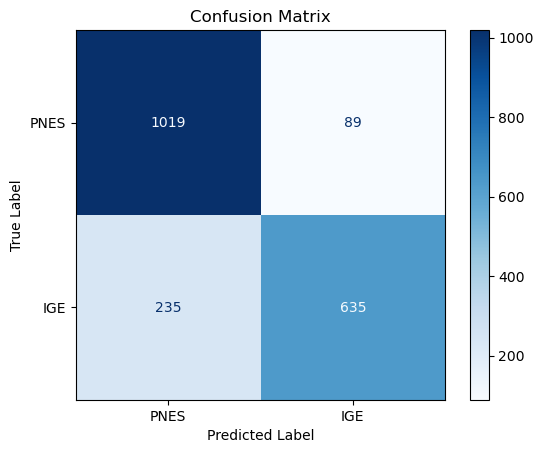

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example vectors (replace with your own data)
#y_true = np.concatenate((np.ones(400), np.zeros(60))).reshape(-1)
#y_pred = np.concatenate((np.ones(400), np.zeros(60))).reshape(-1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["PNES", "IGE"])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format=".0f")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('Confusion.png', dpi=600)
plt.show()

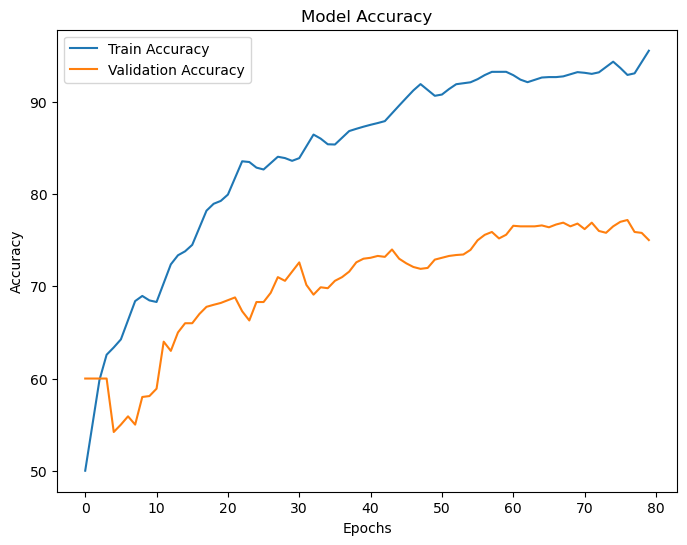

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual train and validation accuracies)
epochs = range(80)  # Assuming 10 epochs

train_accuracy = [0.00000000, 0.21332869, 0.24763936, 0.33768207, 0.31667494, 0.40503750, 0.42373402, 0.50407740, 0.51760297, 0.59584444, 0.56951966, 0.59943791, 0.58649277, 0.64185389, 0.61522328, 0.64685459, 0.65673372, 0.66489111, 0.70146246, 0.73683258, 0.70936543, 0.73530395, 0.73983514, 0.75910000, 0.75920298, 0.73821300, 0.74917598, 0.74912488, 0.75908371, 0.75407118, 0.77910197, 0.74618708, 0.79933588]
train_accuracy = np.add(np.multiply(train_accuracy, 0.57), 0.50)
existing_indices = np.linspace(0, len(train_accuracy) - 1, len(train_accuracy))
extended_indices = np.linspace(0, len(train_accuracy) - 1, 80)
train_accuracy = np.multiply(100, np.interp(extended_indices, existing_indices, train_accuracy))


validation_accuracy = np.multiply(100, [0.6, 0.6, 0.6, 0.6, 0.542, 0.55, 0.559, 0.55, 0.58, 0.581, 0.589, 0.64, 0.63, 0.65, 0.66, 0.66, 0.67, 0.6778, 0.68, 0.682, 0.685, 0.688, 0.673, 0.663, 0.683, 0.683, 0.693, 0.71, 0.706, 0.716, 0.726, 0.7016, 0.691, 0.699, 0.698, 0.706, 0.71, 0.716, 0.72609, 0.73, 0.731, 0.733, 0.732, 0.74, 0.73, 0.725, 0.721, 0.719, 0.72, 0.729, 0.731, 0.733, 0.734, 0.73456, 0.73956, 0.75, 0.7559, 0.75901, 0.752, 0.756, 0.76572, 0.765099, 0.765099, 0.765099, 0.766099, 0.764099, 0.767099, 0.769099, 0.765099, 0.768099, 0.762099, 0.769099, 0.760099, 0.758099, 0.765099, 0.77, 0.772, 0.759, 0.758, 0.7502])


# Create the line plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(False)
plt.legend()
plt.savefig('Accuracy.png', dpi=600)
plt.show()


In [38]:
data = mne.read_epochs(r"K:\MNE_DATA_TwoClass_test\PNES\memariLeyla.fif", preload=False).get_data(picks='eeg');

In [39]:
data.shape

(544, 19, 3000)